# Imports

In [1]:
import os
import pandas as pd

import librosa as lib

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import random as rd
import pickle
import scipy
from scipy.signal import hilbert
import time
from datetime import timedelta as td

import torch
from torch.utils.data import DataLoader

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchaudio.utils import download_asset

from torchvision.io import read_image

from IPython.display import Audio

from useful_functions import *

import keras
from keras import layers
from keras import regularizers

# Tests

In [17]:
file = "file0.wav"
noised = "out.wav"

waveform, sr = torchaudio.load(file)
waveform_noised, sr_noised = torchaudio.load(noised)
waveform_noised[0] = waveform_noised[0]/max(np.abs(waveform_noised[0]))

In [18]:
spectrogram = T.Spectrogram(n_fft=512)

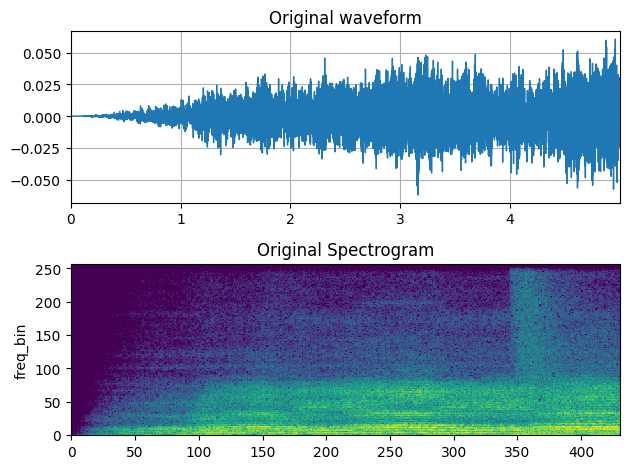

In [19]:
spec = spectrogram(waveform)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sr, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="Original Spectrogram", ax=axs[1])
fig.tight_layout()

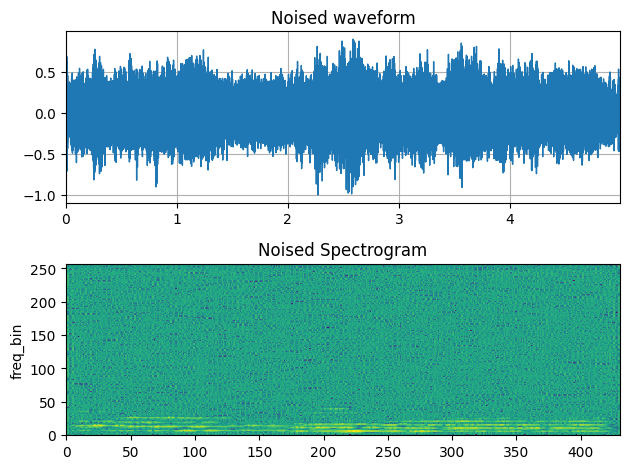

In [20]:
spec_noised = spectrogram(waveform_noised)

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform_noised, sr_noised, title="Noised waveform", ax=axs[0])
plot_spectrogram(spec_noised[0], title="Noised Spectrogram", ax=axs[1])
fig.tight_layout()

In [21]:
pitch = F.detect_pitch_frequency(waveform, sr)
pitch_noised = F.detect_pitch_frequency(waveform_noised, sr_noised)

loudness = F.loudness(waveform,sr)
loudness_noised = F.loudness(waveform_noised,sr_noised)

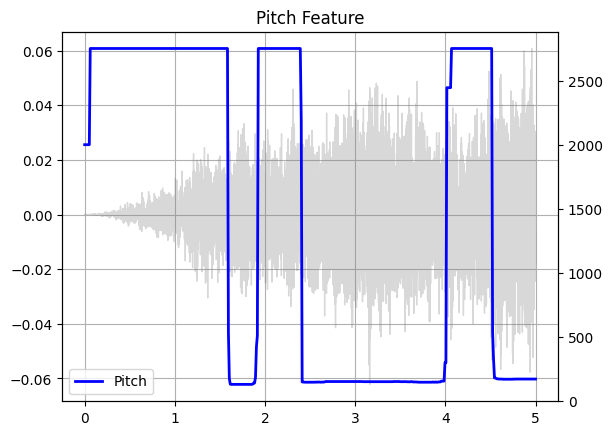

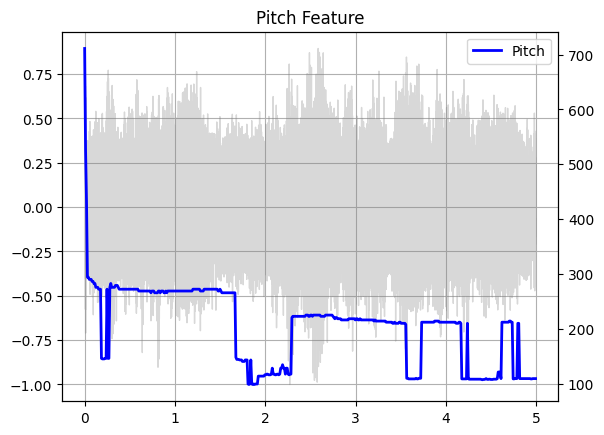

In [22]:
plot_pitch(waveform, sr, pitch)
plot_pitch(waveform_noised, sr_noised, pitch_noised)

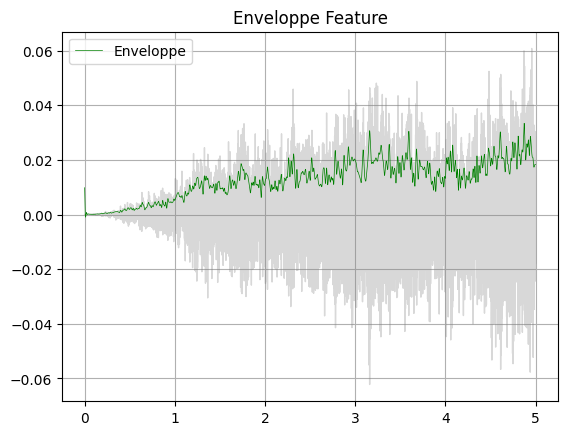

In [8]:
plot_enveloppe(waveform,sr)

# Transform comparisons

In [6]:
wavefiles = data_wave_generation(["Grego_chant.wav"],False)

In [10]:
sr = 22050

spectrum_files = []
mfcc_files = []
spectrogram_files = []
mel_spectrogram_files = gen_spectrogramm(wavefiles,sr)
chroma_stft_files = []

In [11]:
from scipy.fft import fft, fftfreq

for el in wavefiles:
    spectrum_el = abs(fft(el))
    spectrum_files.append(spectrum_el)

    mfcc_el = lib.feature.mfcc(y=el,sr=sr,n_mfcc=40)
    mfcc_files.append(mfcc_el)

    spectrogram_el = lib.stft(y=el,n_fft=2048,hop_length=864)
    spectrogram_files.append(spectrogram_el)

    chroma_stft_el = lib.feature.chroma_stft(y=el,sr=sr,hop_length=864)
    chroma_stft_files.append(chroma_stft_el)

In [12]:
rec_mfcc_files = []
rec_spec_files = []
rec_mel_files = []

In [13]:
for el in mfcc_files:
    rec_mfcc_files.append(lib.feature.inverse.mfcc_to_audio(mfcc=el))

for el in spectrogram_files:
    rec_spec_files.append(lib.griffinlim(S=el,hop_length=864,n_fft=2048))

for el in mel_spectrogram_files:
    rec_mel_files.append(lib.feature.inverse.mel_to_audio(M=el,sr=sr,hop_length=864))


In [15]:
print(np.shape(wavefiles),np.shape(rec_mfcc_files),np.shape(rec_spec_files),np.shape(rec_mel_files))

(720, 110250) (720, 110080) (720, 109728) (720, 109728)


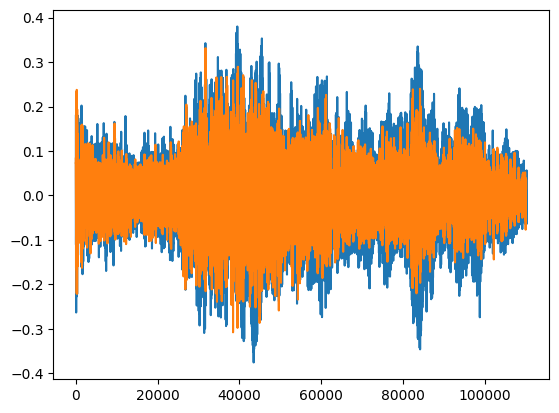

In [36]:
plt.figure()
plt.plot(wavefiles[154])
plt.plot(rec_mfcc_files[154])
plt.show()

In [29]:
def compute_mse(l1,l2):

    n1 = np.shape(l1)
    n2 = np.shape(l2)
    s = min(n1[1],n2[1])

    l = []

    for i in range(n1[0]):
        l.append(np.square(l1[i][:s]-l2[i][:s]))
    
    mse = np.mean(np.array(l))

    return mse

In [31]:
mse1 = compute_mse(wavefiles,rec_mfcc_files)
mse2 = compute_mse(wavefiles,rec_spec_files)
mse3 = compute_mse(wavefiles,rec_mel_files)

In [32]:
print(mse1, mse2, mse3)

0.0051903035 0.0042932983 0.0070352308


In [33]:
spec_mfcc = []
spec_spec = []
spec_mel = []

In [34]:
for el in rec_mfcc_files:
    spec_mfcc.append(abs(fft(el)))
for el in rec_spec_files:
    spec_spec.append(abs(fft(el)))
for el in rec_mel_files:
    spec_mel.append(abs(fft(el)))

In [35]:
mse4 = compute_mse(spectrum_files,spec_mfcc)
mse5 = compute_mse(spectrum_files,spec_spec)
mse6 = compute_mse(spectrum_files,spec_mel)

print(mse4, mse5, mse6)

260.53717 278.15323 349.75604
